# Exercise: Improving a logistic regression model

In the previous exercise, we fit a simple logistic regression model to predict the chance of an avalanche. This time, we'll improve its performance by using multiple features intelligently.

## Data visualisation

Let's load our data.

In [2]:
import pandas
#!pip install statsmodels
#!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/graphing.py
#!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/avalanche.csv

#Import the data from the .csv file
url = "https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/avalanche.csv"
dataset = pandas.read_csv(url, delimiter="\t", index_col=0)

# Split our data into training and test
import sklearn.model_selection
train, test = sklearn.model_selection.train_test_split(dataset, test_size=0.25, random_state=10)

print("Train size:", train.shape[0])
print("Test size:", test.shape[0])

#Let's have a look at the data
print(train.head())

Train size: 821
Test size: 274
     avalanche  no_visitors  surface_hoar  fresh_thickness  wind  weak_layers  \
176          0            9      5.142447         9.877195     6            8   
114          1            3      8.170281         9.136835    34            7   
869          0            3      1.979579         9.497017    10            8   
775          1            0      1.999078         9.337908    21            6   
181          1            9      6.854401         6.099359    22            5   

     tracked_out  
176            1  
114            0  
869            0  
775            0  
181            0  


We have numerous features available:

* `surface_hoar` is how disturbed the surface of the snow is.
* `fresh_thickness` is how thick the top layer of snow is, or 0 if there's no fresh snow on top.
* `wind` is the top wind speed that day, in km/h.
* `weak_layers` is the number of layers of snow that aren't well-bound to other layers.
* `no_visitors` is the number of hikers who were on the trail that day.
* `tracked_out` is a `1` or `0`. A `1` means that the snow has been trampled heavily by hikers.

## Simple logistic regression

Let's make a simple logistic regression model and assess its performance with accuracy.



In [3]:
import sklearn
from sklearn.metrics import accuracy_score
import statsmodels.formula.api as smf

# Perform logistic regression.
model = smf.logit("avalanche ~ weak_layers", train).fit()

# Calculate accuracy
def calculate_accuracy(model):
    '''
    Calculates accuracy
    '''
    # Make estimations and convert to categories
    avalanche_predicted = model.predict(test) > 0.5

    # Calculate what proportion were predicted correctly
    # We can use sklearn to calculate accuracy for us
    print("Accuracy:", accuracy_score(test.avalanche, avalanche_predicted))

calculate_accuracy(model)

Optimization terminated successfully.
         Current function value: 0.616312
         Iterations 5
Accuracy: 0.6167883211678832


Let's see how we can improve our model.

## Utilizing multiple features

Most of our features seem like they could be useful, least in theory. Let's try a model with all available features.

In [4]:
# Perform logistic regression.
model_all_features = smf.logit("avalanche ~ weak_layers + surface_hoar + fresh_thickness + wind + no_visitors + tracked_out", train).fit()
calculate_accuracy(model_all_features)

Optimization terminated successfully.
         Current function value: 0.459347
         Iterations 7
Accuracy: 0.7846715328467153


That's a big improvement on the simpler model with which we've been working. 

To understand why, we can look at the summary information.

In [5]:
model_all_features.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              avalanche   No. Observations:                  821
Model:                          Logit   Df Residuals:                      814
Method:                           MLE   Df Model:                            6
Date:                Tue, 02 Sep 2025   Pseudo R-squ.:                  0.3305
Time:                        16:44:23   Log-Likelihood:                -377.12
converged:                       True   LL-Null:                       -563.33
Covariance Type:            nonrobust   LLR p-value:                 2.372e-77
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.0107      0.443     -9.043      0.000      -4.880      -3.141
weak_layers         0.3733      0.034     10.871      0.000       0.306       0.441
surface_hoar        0.3306      0.035      9.424      0.000       0.262       0.399
fresh_thickness    -0.0220      0.030     -0.732      0.464      -0.081       0.037
wind                0.1009      0.009     11.149      0.000       0.083       0.119
no_visitors        -0.1060      0.032     -3.262      0.001      -0.170      -0.042
tracked_out        -0.0664      0.181     -0.367      0.713      -0.420       0.288
===================================================================================
"""

Take a look at the P column, recalling that values less than 0.05 mean we can be confident that this parameter is helping the model make better predictions.

Both `surface_hoar` and `wind` have very small values here, meaning they're useful predictors and probably explain why our model is working better. If we look at the `coef` (which states _parameters_) column we see that these have positive values. This means that higher winds and greater amounts of surface hoar result in higher avalanche risk.

## Simplifying our model

Looking at the summary again, we can see that `tracked_out` (how trampled the snow is), and `fresh_thickness` have large p-values. This means they aren't useful predictors. Let's see what happens if we remove them from our model:

In [6]:
# Perform logistic regression.
model_simplified = smf.logit("avalanche ~ weak_layers + surface_hoar + wind + no_visitors", train).fit()
calculate_accuracy(model_simplified)

Optimization terminated successfully.
         Current function value: 0.459760
         Iterations 7
Accuracy: 0.781021897810219


Our new model works very similarly to the old one! In some circumstances, simplifying a model like this can even improve it because it becomes less likely to overfit.

## Careful feature selection

Usually, we don't just pick features blindly. Let's think about what we've just done: we removed how much fresh snow was in a model, trying to predict avalanches. Something seems off. Surely avalanches are much _more_ likely after it has snowed? Similarly, the number of people on the track seems unrelated to how many avalanches there were, but we know that people often can trigger avalanches.

Let's review our earlier model again:

In [7]:
model_all_features.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              avalanche   No. Observations:                  821
Model:                          Logit   Df Residuals:                      814
Method:                           MLE   Df Model:                            6
Date:                Tue, 02 Sep 2025   Pseudo R-squ.:                  0.3305
Time:                        16:45:03   Log-Likelihood:                -377.12
converged:                       True   LL-Null:                       -563.33
Covariance Type:            nonrobust   LLR p-value:                 2.372e-77
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.0107      0.443     -9.043      0.000      -4.880      -3.141
weak_layers         0.3733      0.034     10.871      0.000       0.306       0.441
surface_hoar        0.3306      0.035      9.424      0.000       0.262       0.399
fresh_thickness    -0.0220      0.030     -0.732      0.464      -0.081       0.037
wind                0.1009      0.009     11.149      0.000       0.083       0.119
no_visitors        -0.1060      0.032     -3.262      0.001      -0.170      -0.042
tracked_out        -0.0664      0.181     -0.367      0.713      -0.420       0.288
===================================================================================
"""

Look at the `fresh_thickness` row. We're told that it has a negative coefficient. This means that as thickness increases, avalanches decrease.

Similarly, `no_visitors` has a negative coefficient, meaning that fewer hikers means more avalanches.

How can this be? Well, while visitors can cause avalanches if there's a lot of fresh snow, presumably they can't easily do so if there's no fresh snow. This means that our features aren't fully independent.

We can tell the model to try to take into account that these features interact by using a multiply sign. Let's try that now.

In [8]:
# Create a model with an interaction. Notice the end of the string where
# we've a multiply sign between no_visitors and fresh_thickness
formula = "avalanche ~ weak_layers + surface_hoar + wind + no_visitors * fresh_thickness"
model_with_interaction = smf.logit(formula, train).fit()
calculate_accuracy(model_with_interaction)

Optimization terminated successfully.
         Current function value: 0.413538
         Iterations 7
Accuracy: 0.8357664233576643


The model has improved to 84% accuracy! Let's look at the summary information:

In [9]:
model_with_interaction.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              avalanche   No. Observations:                  821
Model:                          Logit   Df Residuals:                      814
Method:                           MLE   Df Model:                            6
Date:                Tue, 02 Sep 2025   Pseudo R-squ.:                  0.3973
Time:                        16:45:42   Log-Likelihood:                -339.51
converged:                       True   LL-Null:                       -563.33
Covariance Type:            nonrobust   LLR p-value:                 1.587e-93
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.9606      0.587     -1.636      0.102      -2.111       0.190
weak_layers                     0.4327      0.039     11.193      0.000       0.357       0.508
surface_hoar                    0.3887      0.039     10.035      0.000       0.313       0.465
wind                            0.1204      0.010     11.607      0.000       0.100       0.141
no_visitors                    -0.9430      0.114     -8.237      0.000      -1.167      -0.719
fresh_thickness                -0.4962      0.069     -7.191      0.000      -0.631      -0.361
no_visitors:fresh_thickness     0.1015      0.013      7.835      0.000       0.076       0.127
===============================================================================================
"""

We can see that the interaction term is helpful; the p-value is less than 0.05. The model is also performing better than our previous attempts.

## Making predictions with multiple features

Very quickly, let's explore what this interaction means by looking at model predictions. 

We'll first graph two independent features in 3D. Let's start with `weak_layers` and `wind`:

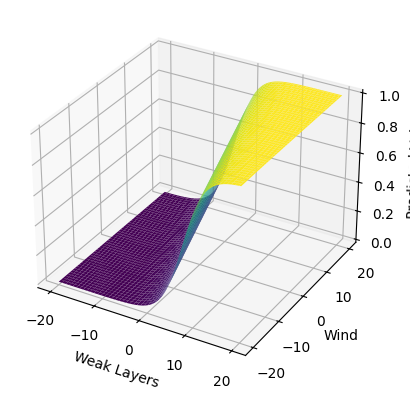

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

def predict(weak_layers, wind, surface_hoar=0, fresh_thickness=0, no_visitors=0):
    return model_with_interaction.predict(pd.DataFrame({
        "weak_layers": weak_layers,
        "wind": wind,
        "surface_hoar": surface_hoar,
        "fresh_thickness": fresh_thickness,
        "no_visitors": no_visitors
    }))

# Generate a graph for weak_layers and wind
weak_layers = np.linspace(-20, 20, 100)
wind = np.linspace(-20, 20, 100)
weak_layers_grid, wind_grid = np.meshgrid(weak_layers, wind)

predicted_values = predict(weak_layers_grid.ravel(), wind_grid.ravel()).to_numpy().reshape(weak_layers_grid.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(weak_layers_grid, wind_grid, predicted_values, cmap='viridis')

ax.set_xlabel("Weak Layers")
ax.set_ylabel("Wind")
ax.set_zlabel("Predicted Values")

plt.show()

There's now a clear s-shaped relationship between the features and probability.

Let's now look at the features that we've said can interact:

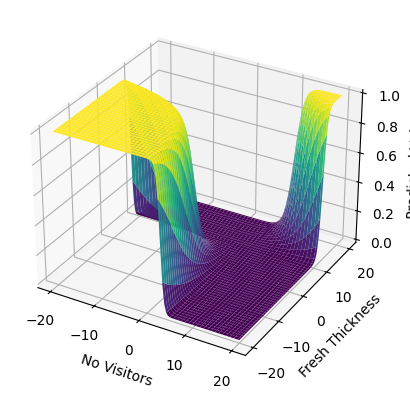

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

def predict(no_visitors, fresh_thickness, weak_layers=0, wind=0, surface_hoar=0):
    return model_with_interaction.predict(pd.DataFrame({
        "no_visitors": no_visitors,
        "fresh_thickness": fresh_thickness,
        "weak_layers": weak_layers,
        "wind": wind,
        "surface_hoar": surface_hoar
    }))

# Generate the graph
no_visitors = np.linspace(-20, 20, 100)
fresh_thickness = np.linspace(-20, 20, 100)
no_visitors_grid, fresh_thickness_grid = np.meshgrid(no_visitors, fresh_thickness)

predicted_values = predict(no_visitors_grid.ravel(), fresh_thickness_grid.ravel()).to_numpy().reshape(no_visitors_grid.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(no_visitors_grid, fresh_thickness_grid, predicted_values, cmap='viridis')

ax.set_xlabel("No Visitors")
ax.set_ylabel("Fresh Thickness")
ax.set_zlabel("Predicted Values")

plt.show()

This graph looks quite different to the other! From any side, we can see an s-shape, but these combine in strange ways.

We can see that the risk goes up on days with lots of visitors _and_ lots of snow. There's no real risk of avalanche when there's a lot of snow but no visitors, or when there are a lot of visitors but no snow.

The fact that it shows high risk when there's no fresh snow and no visitors could be due to rain, which keeps visitors and snow clouds away, but results in avalanches of the older snow. To confirm this, we'd need to explore the data in more depth, but we'll stop here for now.

## Summary

Well done! Let's recap. We've:

* Improved our simple model by adding more features. 
* Practiced interpreting our model coefficients (parameters) from the model summary.
* Eliminated unnecessary features.
* Explored how sometimes it's important to think about what your data really means.
* Created a model that combined features to give a superior result.